In [1]:
#необходимые пакеты 
import ee, geemap, os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import scipy

In [2]:
#geemap.update_package()


In [3]:
ee.Initialize()

### Границы региона 

In [4]:
region_boundary = geemap.geojson_to_ee('data/budenovsk_district_boundaries.geojson')

Budenovsk = geemap.Map(zoom = 10)

Budenovsk.centerObject(region_boundary)

Budenovsk.addLayer(region_boundary ,{'color' : "FF0000"}, 'Границы региона' )

Budenovsk

Map(center=[44.745544055004785, 44.14114333519604], controls=(WidgetControl(options=['position'], widget=HBox(…

### подготовка коллекции для дальнейшей обработки

In [5]:
# возьмем коллекцию сентинел и обработаем ее немного
def masking(img) : 
    cloudProb = img.select('MSK_CLDPRB')  # покрытие облаками
    snowProb = img.select('MSK_SNWPRB') # покрытие снегом
    cloud = cloudProb.lt(1) # создали бинарную маску иными словами просто все что имеет значение меньше 5 одна группа выше другая
                            # а мы помним что пиксели принимают значения от 0 до 255
    snow = snowProb.lt(1) # тоже самое что с облаками
    scl = img.select('SCL') # слой с классификатором(есть в sentinel 2 уровня обработки 2А)
    shadow = scl.neq(3);# 3 в классификации это тени от облаков
    cirrus_medium = scl.neq(8) # тоже по классификации облака 
    cirrus_high = scl.neq(9) # аналогично облака
    cirrus = scl.neq(10); # 10 это перистые облака или цирусы
    masked_img = img.updateMask(cloud).updateMask(shadow).updateMask(cirrus).updateMask(cirrus_medium).updateMask(cirrus_high)
    return(masked_img)

def clipper_region(image):
    clipped = image.clip(region_boundary.geometry())
    return  clipped 

#создали коллекцию с изображениями
start = ee.Date('2018-09-01')
finish = ee.Date('2019-09-01')
sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(region_boundary.geometry()) \
    .filterMetadata("CLOUD_COVERAGE_ASSESSMENT", 'less_than', 20.0) \
    .filterMetadata('SNOW_ICE_PERCENTAGE','less_than', 5.0) \
    .filterDate(start, finish)  \
    .map(masking).map(clipper_region)
sentinel2_collection_list = sentinel2_collection.toList(sentinel2_collection.size().getInfo())

#вынимаем уникальные даты из датасета
sentinel2_collection_list = sentinel2_collection.toList(sentinel2_collection.size().getInfo())
sentinel2_time_list = []
for i in range(sentinel2_collection.size().getInfo()):
    img = ee.Image(sentinel2_collection_list.get(i))
    time = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    sentinel2_time_list.append(time)

#уникальные даты из датасета
unique_dates = sorted(list(set(sentinel2_time_list)))

diff = finish.difference(start , 'day')
Range = ee.List.sequence(0, diff.subtract(1)).map(lambda day :  start.advance(day,'day'))
def day_mosaics(date , newlist):
    date = ee.Date(date)
    newlist = ee.List(newlist)
    
    filtered = sentinel2_collection.filterDate(date , date.advance(1,'day'))
    
    image = ee.Image(filtered.mosaic())
    
    return ee.List(ee.Algorithms.If(filtered.size(), newlist.add(image), newlist))
sentinel2_collection_mosaic = ee.ImageCollection(ee.List(Range.iterate(day_mosaics, ee.List([]))))

In [25]:
#визуал для сентинел 2 
visualization = {"min": 0.0, "max": 2000,"bands": ['B4', 'B3', 'B2']}


['2019-02-19',
 '2019-03-21',
 '2019-03-26',
 '2019-03-31',
 '2019-04-25',
 '2019-04-28',
 '2019-04-30',
 '2019-05-15',
 '2019-05-20',
 '2019-05-25',
 '2019-05-28',
 '2019-05-30',
 '2019-06-07',
 '2019-06-09',
 '2019-06-14',
 '2019-07-04',
 '2019-07-19',
 '2019-07-29',
 '2019-08-03',
 '2019-08-08',
 '2019-08-13',
 '2019-08-18',
 '2019-08-28']

In [7]:
def sentinel2_NDTI(image):
    NDTI = image.normalizedDifference(['B11', 'B12']).rename('NDTI')
    return image.addBands([NDTI])

MiniNDTI = sentinel2_collection_mosaic.map(sentinel2_NDTI).select('NDTI').min().rename('minNDTI').reproject(crs= 'EPSG:32638' , crsTransform = [60, 0, 300000, 0, -60, 5000040])





In [30]:
#Создание датафрейма с динамикой NDTI 
collection_size = sentinel2_collection_mosaic.size().getInfo()
NDTI_list = sentinel2_collection_mosaic.map(sentinel2_NDTI).select('NDTI').toList(collection_size)
NDTI_collection = ee.Image().reproject(crs = 'EPSG:32638' , crsTransform = [60, 0, 300000, 0, -60, 5000040])
for i in range(collection_size): 
    img = ee.Image(NDTI_list.get(i)). \
    select('NDTI'). \
    rename(unique_dates[i]). \
    reproject(crs= 'EPSG:32638' , crsTransform = [60, 0, 300000, 0, -60, 5000040])
    NDTI_collection = NDTI_collection.addBands(img) #датафрейм с каналами
NDTI_collection.getInfo()

{'type': 'Image',
 'bands': [{'id': 'constant',
   'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 0},
   'crs': 'EPSG:32638',
   'crs_transform': [60, 0, 300000, 0, -60, 5000040]},
  {'id': '2019-02-19',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': -1,
    'max': 1},
   'crs': 'EPSG:32638',
   'crs_transform': [60, 0, 300000, 0, -60, 5000040]},
  {'id': '2019-03-21',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': -1,
    'max': 1},
   'crs': 'EPSG:32638',
   'crs_transform': [60, 0, 300000, 0, -60, 5000040]},
  {'id': '2019-03-26',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': -1,
    'max': 1},
   'crs': 'EPSG:32638',
   'crs_transform': [60, 0, 300000, 0, -60, 5000040]},
  {'id': '2019-03-31',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': -1,
    'max': 1},
   'crs': 'EPSG:32638',
   'crs_transform': [60, 0, 300000, 0, -60, 5000040]},
  {'id': '

NameError: name 'field_ee' is not defined

In [8]:
Budenovsk.addLayer(MiniNDTI, {'min' : 0 , 'max' : 0.2, 'palette' :['FFFF00','FFF000','FF0000' ]}, "minNDTI") # добавили на карту

In [9]:
Archangelskoe = gpd.read_file('data/archangelskoe_wgs84.geojson' )
Praskoveya = gpd.read_file('Data/praskoveya_wgs84.geojson')

Archangelskoe['type'] = 'PP'
Praskoveya['type'] = 'TT'

fields = Praskoveya.append(Archangelskoe)[['type','geometry']]
fields['number'] = [i for i in range(0,fields.shape[0])]
fields_ee = geemap.geopandas_to_ee(fields)




In [10]:
Budenovsk.add_styled_vector(fields_ee, column = 'type',palette = ['00FF2A',"FF8001" ], layer_name = 'разные технологии обработки') 


In [39]:

#minNDTI_DF = MiniNDTI.select('minNDTI').sampleRegions(fields_ee)
#geemap.ee_export_vector(minNDTI_DF, filename='C:/Users/User/Google Диск/python_notebooks/Archangelskoe_NDTI_project/Data/minNDTI.csv')
#NDTI_collection_df = NDTI_collection.reduceRegions(fields_ee, ee.Reducer.median())
#geemap.ee_export_vector(NDTI_collection_df, filename = "C:/Users/User/Google Диск/python_notebooks/Archangelskoe_NDTI_project/Data/NDTI_collection.csv")


Generating URL ...
Please wait ...
An error occurred while downloading.


ValueError: [Errno 2] No such file or directory: 'C:\\Users\\User\\Google Диск\\python_notebooks\\Archangelskoe_NDTI_project\\Data\\NDTI_collection.csv'

In [12]:
minNDTI_pd_df = pd.read_csv('Data/minNDTI.csv')
minNDTI_pd_df

minNDTI_pd_df[['field_№', 'number']] = minNDTI_pd_df['system:index'].str.split('_', 1, expand=True)
minNDTI_pd_df = minNDTI_pd_df.drop(["system:index",'number' ], 1)

minNDTI_pd_df

,type,minNDTI,field_№
0,TT,0.022935,0
1,TT,0.044681,0
2,TT,0.043812,0
3,TT,0.003171,0
4,TT,-0.001263,0
...,...,...,...
81909,PP,0.037835,269
81910,PP,0.038556,269
81911,PP,0.045058,269
81912,PP,0.032397,269


minNDTI                      \
     count_nonzero      mean    median   
type                                     
PP         39013.0  0.041661  0.036770   
TT         42731.0  0.011008  0.008413   

                                               
                        kholmogorov_norm_test  
type                                           
PP    распределение отличается от нормального  
TT    распределение отличается от нормального

выборки различаются при p уровне значимости 0.0


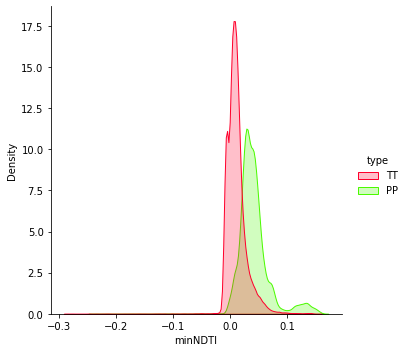

In [14]:
# проверка на нормальность тестом холмогорова 

#sns.set_style("whitegrid") 

sns.set_palette("prism_r")


def kholmogorov_norm_test(x):
    if scipy.stats.kstest(x, 'norm')[1] < 0.05:
        return('распределение отличается от нормального')
    else:
        return('распределение нормальное')
NDTI_sevoob_stats = minNDTI_pd_df[['type', 'minNDTI']].groupby(['type'] ).aggregate([np.count_nonzero, np.mean, np.median, kholmogorov_norm_test])

display(NDTI_sevoob_stats)

dentisty = sns.displot(minNDTI_pd_df, x='minNDTI',
                       hue="type", 
                       kind="kde", 
                       fill=True)

x = minNDTI_pd_df[minNDTI_pd_df.type == 'TT']["minNDTI"]
y = minNDTI_pd_df[minNDTI_pd_df.type != 'TT']["minNDTI"]
if scipy.stats.kruskal(x,y)[1] < 0.05:
    res = 'выборки различаются'
else:
    res = 'выборки не различаются'
print(f'{res} при p уровне значимости {scipy.stats.kruskal(x,y)[1]}')    
    

In [15]:
minNDTI_df = minNDTI_pd_df[["minNDTI","field_№"]].groupby(['field_№'] ).aggregate([np.count_nonzero, np.mean, np.median]).reset_index()
minNDTI_df.columns = ['number','pixel_count','minNDTI_mean','minNDTI_median']
minNDTI_df.number = minNDTI_df.number.astype(np.int64)
minNDTI_df.head(10)

,number,pixel_count,minNDTI_mean,minNDTI_median
0,0,252.0,0.002339,0.000645
1,1,374.0,0.010333,0.009656
2,10,627.0,0.017505,0.016913
3,100,165.0,-0.005966,-0.005239
4,101,170.0,-0.004193,-0.005480
5,102,182.0,-0.006583,-0.008326
6,103,247.0,0.012074,0.010599
7,104,466.0,0.012044,0.009383
8,105,471.0,0.007455,0.007214
9,106,464.0,-0.005643,-0.006186


#### Короткое резюме 
все отлично получилось , различия между выборками есть
1) нужно посмотреть другие годы , и покрасивее сделать графику 
2) переходить к анализу по культурам (нужно будет делать кластерный анализ по группам 

### Работа по кластерам


мы получили данные по группам, сейчася их добавлю и будем думать что делать дальше 

In [17]:
CLUSTER_NDVI = pd.read_csv('Data/RESULT_CLUSTER_NDVI_DATA.csv')


In [18]:
CLUSTER_NDVI.columns

Index(['Unnamed: 0', '2019-02-18', '2019-06-10', '2018-11-01', '2018-12-03',
       '2019-07-12', '2019-08-13', '2018-09-14', '2019-03-22', '2019-04-23',
       '2019-05-25', '2019-07-28', '2018-09-30', '2019-06-26', '2019-08-29',
       '2019-03-06', '2019-04-07', '2019-05-09', '2018-10-16', '2018-11-17',
       'number', 'groups', 'type', 'PC_1_45%', 'PC_2_20%', 'PC_3_16%',
       'geometry'],
      dtype='object')

In [19]:
CLUSTER_NDVI = CLUSTER_NDVI.merge(minNDTI_df , on = 'number')

### Визуализация того что получилось по кластерам

<AxesSubplot:xlabel='minNDTI_median', ylabel='type'>

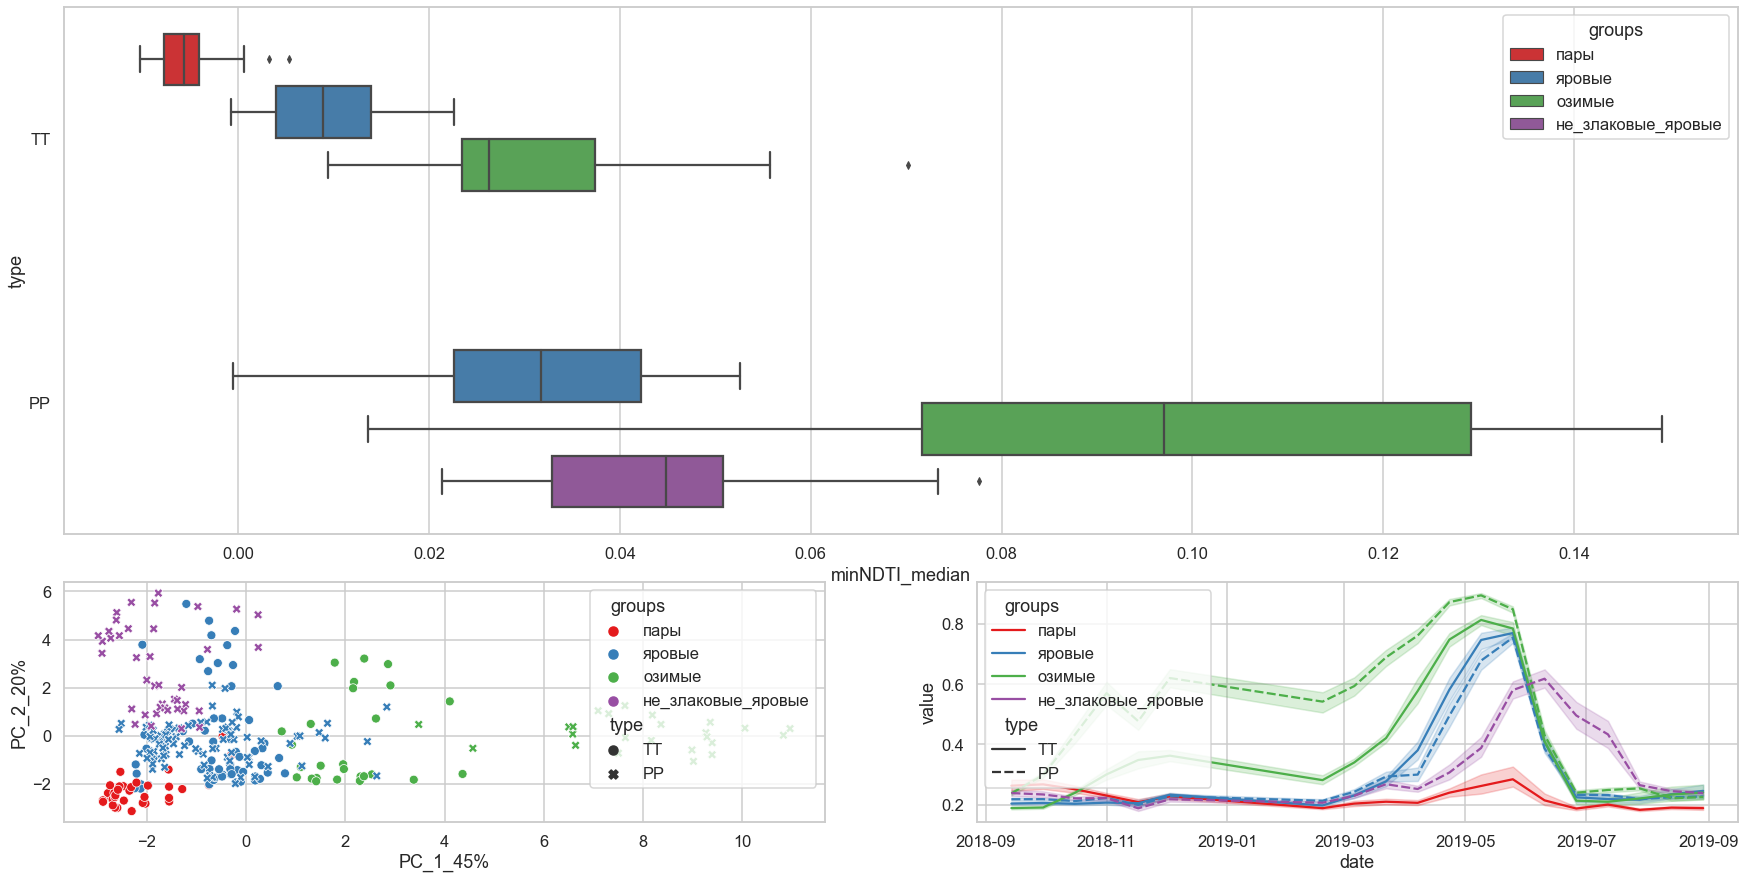

In [20]:
sns.set_context("talk")
sns.set_style("whitegrid")


CLUSTER_NDVI_date = CLUSTER_NDVI.melt(id_vars = ['number', 'type','groups'], value_vars = CLUSTER_NDVI.columns[1:20], var_name = 'date')
CLUSTER_NDVI_date.date = pd.to_datetime(CLUSTER_NDVI_date.date)

gridsize = (3, 2)
fig = plt.figure(figsize=(30, 15))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))


scatter = sns.scatterplot(data=CLUSTER_NDVI, x="PC_1_45%", y="PC_2_20%", hue="groups",style = 'type', palette='Set1', ax=ax2)
time_scale = sns.lineplot(x="date", y="value", hue="groups",style ='type', data = CLUSTER_NDVI_date, palette='Set1', ax=ax3)
sns.boxplot( x="minNDTI_median", y="type", hue="groups", data=CLUSTER_NDVI, orient='h', color='groups',
            palette='Set1', saturation=0.75, width=0.8, dodge=True,
            fliersize=5, linewidth=None, whis=1.5,ax=ax1   )



мне очень нравится то , что я вижу, завтра надо посчитать статистику (можно попробовать вернуться Кmeans и посчитать межгруповую разницу) 
сейчас хорошие различия на качественном уровне, нужно шагнуть дальше

имеет смысл посмотреть динамику min NDTI по времени(для этого я немного откачу эту версию и сделаю выборку по динамике minNDTI(сразу буду брать медианы из каждого поля) 
это тоже можно как то просчитать 
ну вообщем то получается очень не плохое исследование , когда с этим закончу можно будет докрутить еще сезон 2017-2018 и будет вообще супер

### Динамика minNDTI

In [65]:
NDTI_time_series = pd.read_csv('Data/NDTI_collection.csv')
NDTI_time_series = NDTI_time_series.merge(CLUSTER_NDVI[['groups','number']], on = 'number').drop(["constant","system:index"], axis = 1)

NDTI_time_series_date = NDTI_time_series.melt(id_vars = ['number', 'type','groups'], value_vars = NDTI_time_series.columns[:23], var_name = 'date')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

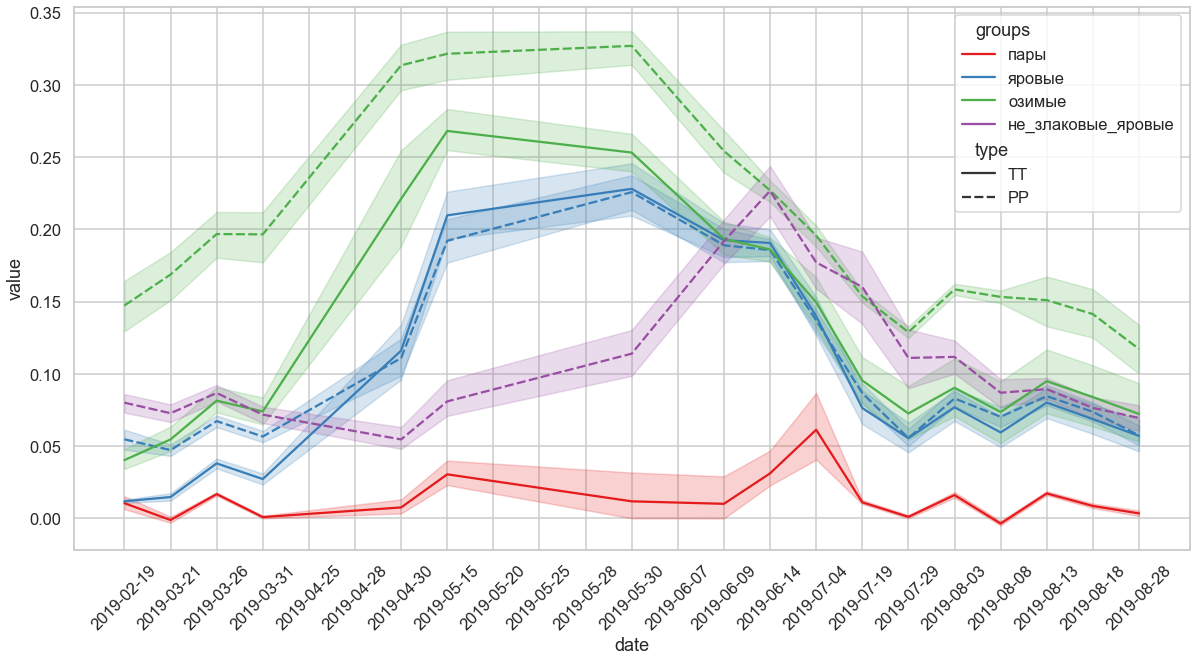

In [129]:
sns.set_context("talk")
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20,10))


NDTI_time = sns.lineplot(x="date", y="value", hue="groups",style ='type', data = NDTI_time_series_date, palette='Set1')
plt.xticks(rotation=45)

### определение срока уборки при помощи производной 

In [98]:
df = CLUSTER_NDVI_date[CLUSTER_NDVI_date['type'] == 'PP']
df = df[df.groups == 'озимые']
df = df[df.number == 135]

In [103]:
df['GRADIEN'] = df['value'].diff()

In [115]:
d = df['date'][df['GRADIEN'] == df['GRADIEN'].max()]